<table>
  <tr>
    <td><p style="font-size:45px; color: #55BBD2">Analysis of light microscopy images in Python</p></td>
    <td><img src="ressources/lmb_logo.svg" alt="LMB Logo" width="500" height="600" align="right"></td>
  </tr>
</table>
<table>
  <tr>
    <td><p style="font-size:15px; color: #55BBD2">Version: June 2023</p></td>
  </tr>
</table>

# Introduction to the course

The course aims to introduce you to the essential knowledge to image processing and analysis of microscopic data in Python. 

At the end of this course, we hope the course attendees will be able to:
- understand and establish an image analysis workflow
- run a Python notebook
- get familiar with relevant Python packages
- load and read microscopic image using the package AICSImageOI
- filter the noise of an image
- extract relevant information from an image using the module regionprops and save the results in an excel sheet

To run the Python notebook, select Kernel and choose the environment 'imaging'.

## Documentation for important python packages

When working in Python, many functions or modules have already been developed and stored in what is called 'package' or 'library'. 

A library is a collection of packages while a package is a collection of modules. 

- [Scikit Image](https://scikit-image.org/docs/stable/api/api.html)
- [Numpy](https://numpy.org/doc/stable/reference/index.html#reference)
- [Matplotlib](https://matplotlib.org/stable/api/index.html)
- [Cellpose](https://cellpose.readthedocs.io/en/latest/api.html)
- [AICSImageIO](https://pypi.org/project/aicsimageio/3.2.1/)

## Downloading data

Let us first download some data while looking at how to load a package. 


In [1]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import os 

def download_and_unzip(url, extract_to='.'):
    http_response = urlopen(url)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)

url = 'https://cloud.mrc-lmb.cam.ac.uk/s/apiQPm28YLRWXeo/download/data.zip'
data_folder = os.path.expanduser('~/Python-course')
download_and_unzip(url, data_folder)

from pathlib import Path
print(f'List of files in the {data_folder} data folder')
for x in (Path(data_folder) / 'data').glob('*'):
    print(f' {str(x.name)}')
 

List of files in the /home/jupyter-uschulze/Python-course data folder
 airyscan-4colors.tif
 target.lif
 example.czi
 nuclei.tif
 example.tif
 tetrahymena.nd2
 example.nd2


# Analysis problem




![title](ressources/data.png)

Let say we are interested in what is happening in each channel within the actin region (Channel 1) that surround each nucleus (Channel 3). 

Our region of interest (ROI) is therefore defined by the region delimited by the actins in Channel 1 that have as a "seed" the nuclei in Channel 3. 

We want to measure:
- the maximal intensity in Channel 0 within this ROI,
- the median intensity in each of the ROI of Channel 1,  
- number of dots in Channel 2 in each of the ROI,

That is enough problem for now so let's get into it :)

To solve the problem and achieve the statistic analysis, we generally need to do have an workflow which generally consists of the following steps:

    Step 1: load and read the image and metadata if necessary
    Step 2: pre-process the image by filtering it if necessary  
    Step 3: find the region of interest by segmentation 
    Step 4: extract the desired information (i.e. measure image properties) in the ROI: mean, max, min, sum, median, mode, ...
    Step 5: display/plot results
    Step 6: save the result

# Loading microscopy image data

For reading various type of microscopy data we suggest AICSImageIO.

[AICSImageIO](https://github.com/AllenCellModeling/aicsimageio) is a Python package that enable an unified and standardized reading of microscopic images in different formats. This package will use Python reader if possible or use Bio-Formats as a backup.

[Bio-Formats](http://www.openmicroscopy.org/bio-formats/) is a software tool for reading and writing life science image data using standardized, open formats. Bio-Formats can supports 162 formats at the moment and the list of what can be supported can be found [here](https://bio-formats.readthedocs.io/en/stable/supported-formats.html).


In [2]:
from aicsimageio import AICSImage

image = AICSImage(data_folder+'/data/airyscan-4colors.tif')

The image and its metadata are now loaded into the variable "image". Next, we read the image and the metadata. 

### Metadata

Metadata store information that describes the data. It includes the number of channels in the images, the name of each channel and emission wavelength associated with each channel, the voxel size and physical size of the image, and many other acquisition parameters.



In [3]:
image.data
image.metadata
image.physical_pixel_sizes
image.shape
image.dims
image.channel_names

['Channel:0:0', 'Channel:0:1', 'Channel:0:2', 'Channel:0:3']

<div class="alert alert-success">

#### Exercise 

In the next cell, get familiar with the contents of the variable "image" and the metadata by printing the values stored in it one by one and understand the outputs. 
    
Hint: use the function print()
    
</div>

### Image dimension and pixel sizes

Next, we will check the different dimensions of our image. To illustrate this, we need to know what a dictionnary is as it is required here.

In [4]:
image.dims

<Dimensions [T: 1, C: 4, Z: 1, Y: 1912, X: 1912]>

In [5]:
for dim, element in enumerate(image.dims.order):
    print(f'Array axis {dim} is {element} with size {image.dims[element][0]}')

print(f'The name of the channels are {image.channel_names}')
print(f'The pixel size in X is {image.physical_pixel_sizes}')
print(f'The pixel size in X is {image.physical_pixel_sizes.X:.4f} microns')
print(f'The pixel size in Y is {image.physical_pixel_sizes.Y:.4f} microns')

Array axis 0 is T with size 1
Array axis 1 is C with size 4
Array axis 2 is Z with size 1
Array axis 3 is Y with size 1912
Array axis 4 is X with size 1912
The name of the channels are ['Channel:0:0', 'Channel:0:1', 'Channel:0:2', 'Channel:0:3']
The pixel size in X is PhysicalPixelSizes(Z=None, Y=0.035290573227957096, X=0.035290573227957096)
The pixel size in X is 0.0353 microns
The pixel size in Y is 0.0353 microns


### What is an image?

A digital image is a finite numeric representation of the intensity values. It is composed of picture elements known as pixels. 

In Python, it can be read as a N-dimensional array.

In [6]:
# import the numpy package used for manipulating images
import numpy as np

# get the array of pixels intensity as a numpy object
data = image.data

# Print the type of the array
print('The data is a ', type(data)) 

# Print the dimension of the array
print('The array has the following shape', data.shape) 


The data is a  <class 'numpy.ndarray'>
The array has the following shape (1, 4, 1, 1912, 1912)


Let us now display an image. 


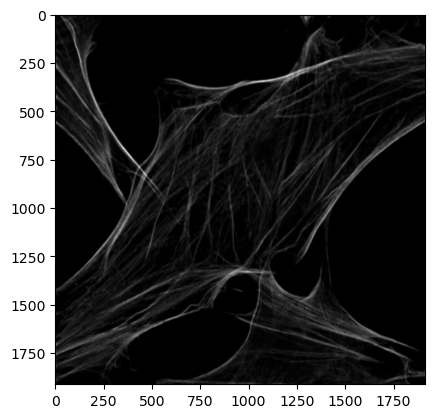

In [7]:
# import matplotlib for loading images
import matplotlib.pyplot as plt

# Let's display the second channel as a 2D image in a figure
plt.imshow(data[0,1,0,:,:], cmap='gray');

<div class="alert alert-success">
       
#### Exercise 

Display the second and third channels in the image and change the colormap cmap value to 'hot'.
    
Hint: use the same function that in the previous cell.
</div>

Now let's display all the channels of the image in a subplot using a `for` loop:

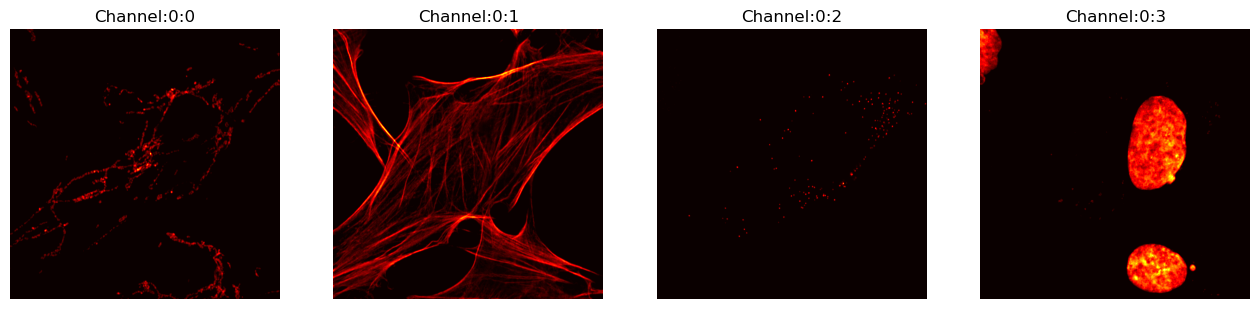

In [8]:
# import matplotlib for displaying images
import matplotlib.pyplot as plt

# compute the number of channels
num_channels = image.shape[1]

# Display the image for each channel
fig, ax = plt.subplots(1, num_channels, figsize=(16,4))
for k  in range(num_channels):    
    ax[k].imshow(image.data[0,k,0], cmap='hot')
    ax[k].set_axis_off()
    ax[k].set_title(image.channel_names[k])    

In the follwing cell, we crop a part of the image, display it in a figure and overlay the pixel values.

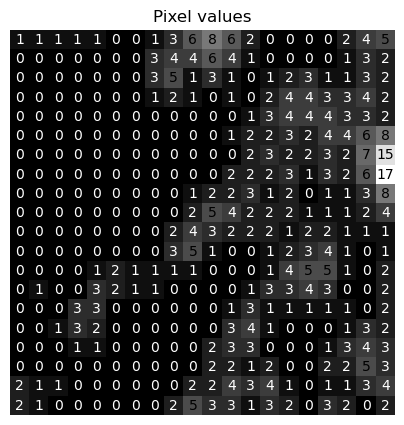

In [9]:
# Crop and downsample the array by a factor of 5
crop = image.data[0, 0, 0, 850:950:5, 900:1000:5] 

# Create a figure with axes
fig, ax = plt.subplots(figsize=(5, 5))

# Display the downsampled array in the figure
plt.imshow(crop, cmap='gray')

# Add the values of the pixel intensity
for i in range(crop.shape[0]):
    for j in range(crop.shape[1]):
        c = 'white' if crop[i, j] < 5 else 'black'
        ax.text(j, i, str(int(crop[i, j])), color=c, ha='center', va='center', size=10)
ax.axis("off")
plt.title('Pixel values');

<div class="alert alert-success">
       
#### Exercise 
    
Modify the previous cell to

1. select a different region within the image and display an overlay of the image with the pixel values,
2. check again the size of the image to be sure of not going out of bounds,
3. choose an appropriate downsampling factor,
4. adjust the figsize for a proper and visible display if necessary.
    
</div>

# Image Filtering and Noise

Filtering is a technique for modifying or enhancing an image. We can filter an image to emphasize certain features or remove other features. Noise filtering is an example of image filtering.

Noise in microscopic image is unavoidable during image acquisition. There are three main categories of noise: 
1. Photon noise, also called shot noise: acquired due to the fluctuation of photon emission to the detector. This is the most dominant noise. It is signal dependent and follows a Poisson distribution. 
2. Dark current or dark noise: accumulated over time due to thermal change as the detector heats up. It is unavoidable but negligible compared to photon noise and is not photon dependent. It follows Poisson distribution. 
3. Readout noise: digital noise acquired during the electronic quantisation of photons. It follows a Gaussian distribution where the standard deviation is constant and the mean is 0.

Dominant noise in fluorescence microscopy follows either a Gaussian distribution or Poisson distribution or both but mostly both. Gaussian noise is additive while Poisson noise is signal dependent. A correct removal of those two different types of noise may therefore differ. Firstly, we will look at how those noise affect the image differently. 

## Simulating noisy images

Here we are going to apply our understanding of what an image is to simulate a new one. <br>
We will add Gaussian and Poisson noise into our image to see the difference in the effect. 

In creating the image, we will use the floor division // operator, which returns the integer value of the quotient. 

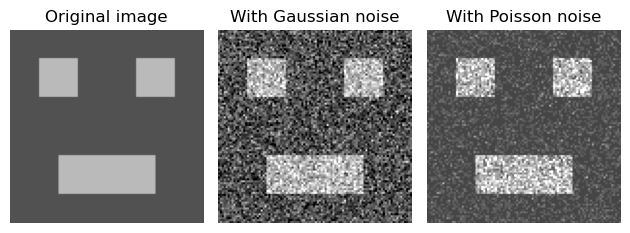

In [10]:
# Create a noise free test image
n = 100
nphotons = 5
data = np.zeros((n,n),dtype=float)+0.5
data[n//4-10:n//4+10, n//4-10:n//4+10] = nphotons
data[n//4-10:n//4+10, 3*n//4-10:3*n//4+10] = nphotons
data[3*n//4-10:3*n//4+10, n//4:3*n//4] = nphotons

# Add a Gaussian noise
mean = 0
stddev = 2
noisy_gauss_img = data + np.random.normal(mean, stddev, data.shape)

# Apply Poisson noise
noisy_poisson_img = np.random.poisson(data)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(data, cmap='gray',vmin=-3,vmax=nphotons+3)
axs[0].set_title('Original image')
axs[0].set_axis_off()

axs[1].imshow(noisy_gauss_img, cmap='gray',vmin=-3,vmax=nphotons+3)
axs[1].set_title('With Gaussian noise')
axs[1].set_axis_off()

axs[2].imshow(noisy_poisson_img, cmap='gray',vmin=-3,vmax=nphotons+3)
axs[2].set_title('With Poisson noise')
axs[2].set_axis_off()

fig.set_tight_layout('tight')


## Noise filtering

There are different types of noise reduction such as smoothing filtering or convolution filtering, median filtering, or frequency filtering. 

As each pixel has a value which represents the image intensity at the spatial position of the pixel, we need to work on each pixel of the image to filter an image.

### Gaussian filter
A smoothing filter uses the principle of convolution to reduce the noise. A convolution process is similar to drawing. The kernel is the pencil that is used for the drawing. So the sharpness of the drawn image really depends on the width of the point of the pencil. In the case of a Gaussian filtering, the Gaussian distribution is used as a kernel. When used for noise filterning, the noise which should have a lower intensity value than the real signal gets smoothed out because of this convolution process. 

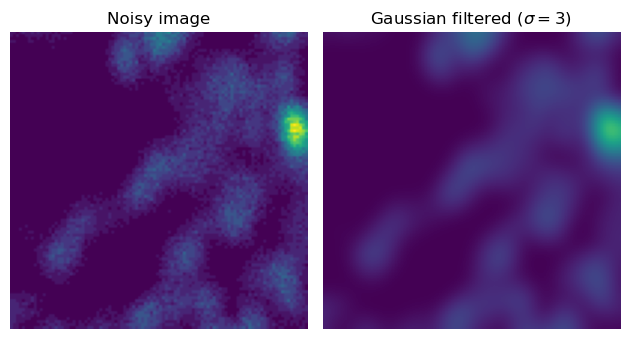

In [11]:
from skimage import filters

# Crop the image and select the first channel
crop = image.data[0, 0, 0, 850:950, 900:1000]

# Gaussian filtering of data with a Gaussian filter of a given sigma
sigma = 3
gaussian_filtered = filters.gaussian(crop.astype(float), sigma)

fig, axs = plt.subplots(1, 2)
vmin, vmax = crop.min(), crop.max()

axs[0].imshow(crop, vmin = vmin, vmax = vmax)                      # original image
axs[0].set_title('Noisy image')
axs[0].set_axis_off()

axs[1].imshow(gaussian_filtered,vmin=vmin,vmax=vmax)                # Gaussian filtered
axs[1].set_title('Gaussian filtered ($\sigma=$'+str(sigma)+')')
axs[1].set_axis_off()

plt.tight_layout()


<div class="alert alert-success">
       
#### Exercise 

Try changing in the previous cell the standard deviation sigma of the Gaussian kernel and observe the change in the Gaussian filtered image.
    
</div>

### Median filter
A different technique for noise filtering is a median filtering. With the median filter, each output pixel is computed as the median value of the input pixel under a chosen window. 

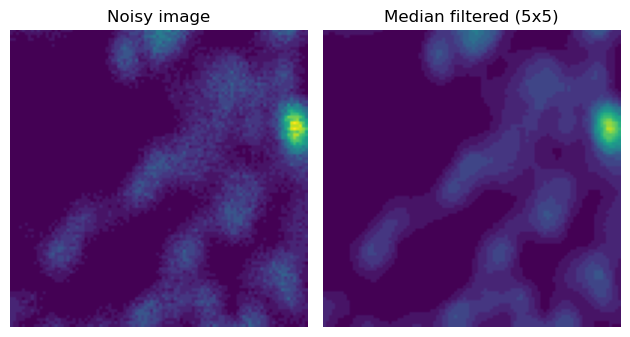

In [12]:
# define the kernel
kernel_size = [5, 5]
median_kernel = np.ones((kernel_size[0], kernel_size[1])) 

# the median kernel is introduced in the second argument of the function 
median_filtered = filters.median(crop, median_kernel) 

fig, axs = plt.subplots(1, 2)

# compute the min and max of the original image to keep the same display range
vmin, vmax = crop.min(), crop.max()

axs[0].imshow(crop, vmin = vmin, vmax = vmax)    
axs[0].set_title('Noisy image')
axs[0].set_axis_off()

axs[1].imshow(median_filtered,  vmin = vmin, vmax = vmax)    
axs[1].set_title('Median filtered (' + str(kernel_size[0]) + 'x' + str(kernel_size[1]) + ')')
axs[1].set_axis_off()

plt.tight_layout()

<div class="alert alert-success">

#### Exercise       

Try changing the size of the median kernel and observe the change in the median filtered image.
    
</div>

# Segmentation

Segmentation is the process of defining which objects in our image we want to measure. The goal is to compute a mask, a black and white image, that divides the image into objects (white) and background (black). 

The goal is to find masks which represents each ROI. The easiest way to do this by simply thresholding the intensity of the image. By this, the mask is defined such that only intensity (pixel) values greater than the threshold value are selected. If we stop at this stage, the problem we may encounter is such that some values within the thresholded region may get discarded because the intensity value is lower than the threshold and the ROI won't be filled. In this case, we may need to find the edge or/and fill the mask region. Another issue that we may encounter as well is that the edges of the regions may overlap so they may be detected or segmented as one. One solution in this case is to use what is called watershed segmentation to detect the flow of the intensity and decide from there whether the regions form only one object or different objects. 

## Thresholding 

The simplest way of doing this is to use a static threshold, where an intensity value is defined as a threshold.

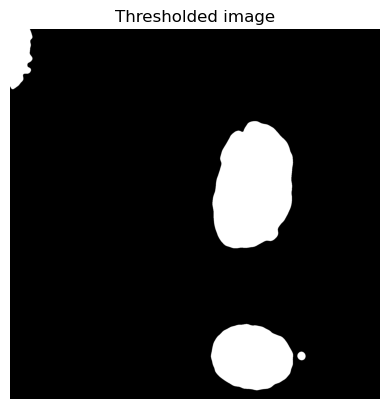

In [13]:
from skimage import filters
import matplotlib.pyplot as plt


nuclei = image.data[0,3,0,:,:] # the object we want to segment and set as markers of our final ROI
nuclei_flt = filters.gaussian(nuclei.astype(float), 10) 

threshold = 5 # change threshold value here to see what happens to the mask that is being displayed below
mask = nuclei_flt >= threshold    
plt.imshow(mask, cmap='gray')
plt.title('Thresholded image')
plt.axis('off');

Lets plot the contour of this mask over the image to judge the quality of the segmentation.

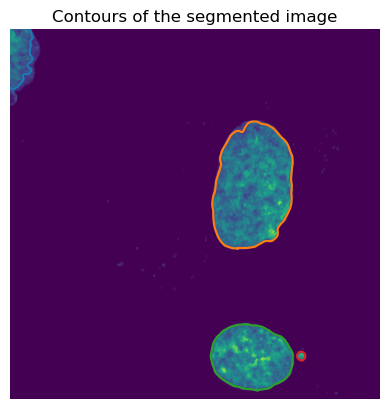

In [14]:
from skimage import measure

contours = measure.find_contours(mask, 0.5)

plt.imshow(nuclei)
# For each elements of the contours
for contour in contours:
    plt.plot(contour[:,1], contour[:,0])

plt.axis('off')
plt.title('Contours of the segmented image');

## Automated thresholding segmentation 

If a static threshold is not suitable, a thresholding algorithm can be used. One example for this is Otsu's method [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method). More thresholding algorithms can be found in the [skimage.filters package](https://scikit-image.org/docs/stable/api/skimage.filters.html). 

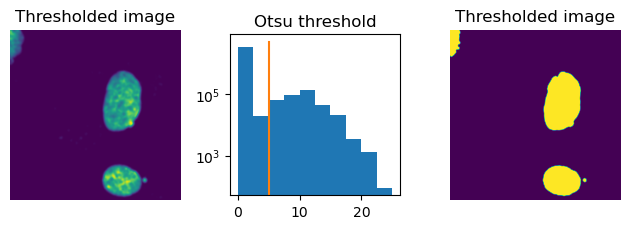

In [15]:
from skimage import filters

# find the threshold value differentiating the signal from background
threshold = filters.threshold_otsu(nuclei_flt) 

# define the threshold mask and close it
nuclei_mask = nuclei_flt > threshold

fig, ax = plt.subplots(1,3)

ax[0].imshow(nuclei_flt)
ax[0].set_title('Thresholded image')
ax[0].set_axis_off()

ax[1].hist(nuclei.ravel(),log=True)
ax[1].plot([threshold, threshold], [0,5e6])
ax[1].set_title('Otsu threshold')
ax[1].set_aspect(5)

ax[2].imshow(nuclei_mask)
ax[2].set_title('Thresholded image')
ax[2].set_axis_off()

plt.tight_layout()

Let's clean up the binary mask using morphology tools from scikit image.

In [ ]:
from skimage import morphology
from skimage import segmentation
from skimage import measure
from skimage import color

# remove artifacts connected to image border
only_large_objects = morphology.remove_small_objects(nuclei_mask, 10000)
cleared = morphology.closing(only_large_objects, morphology.square(35))
cleared = segmentation.clear_border(cleared)

# label image regions
nuclei_label = measure.label(cleared)

# label image to rgb 
nuclei_label_overlay = color.label2rgb(nuclei_label, image=10*nuclei, bg_label=0)

fig, ax = plt.subplots(2, 3, figsize=(5,5))

ax[0,0].imshow(nuclei_flt)
ax[0,0].set_title('Filtered Nuclei channel')
ax[0,0].set_axis_off()


ax[0,1].imshow(nuclei_mask)
ax[0,1].set_title('Otsu threshold')
ax[0,1].set_axis_off()

ax[0,2].imshow(only_large_objects)
ax[0,2].set_title('Large Objects')
ax[0,2].set_axis_off()

ax[1,0].imshow(cleared)
ax[1,0].set_title('Cleared mask')
ax[1,0].set_axis_off()

ax[1,1].imshow(nuclei_label)
ax[1,1].set_title('Label image')
ax[1,1].set_axis_off()

ax[1,2].imshow(nuclei_label_overlay)
ax[1,2].set_title('Mask and image overlay')
ax[1,2].set_axis_off()

plt.tight_layout()

## Watershed-based segmentation
The segmentation of the nuclei is pretty straightforward because they are well separated. In same cases however, the objects we want to segment overlap, making it difficult to discern the different regions. In this case, we would need to add extra step into the image segmentation in order to discern the objects. Watershed segmentation is useful for this purpose. It is generally used for separating different objects. Watershed algorithm treats pixels values as a local topography (elevation) so the goal is to follow the flow of the elevation and find the watershed lines from which the edge of each of the regions are deduced. We use this principle to extract our previously defined ROIs: the actin region in Channel-1 having the two nuclei as markers and the seeds of the segmentation. 

In [ ]:
import numpy as np
actin  = image.data[0,1,0,:,:] #  the channel we want to segment 

fig, axs = plt.subplots(1,2)
axs[0].imshow(actin)
axs[0].set_title('Actin channel')
axs[0].set_axis_off()

axs[1].imshow(nuclei)
axs[1].set_title('Nuclei channel')
axs[1].set_axis_off()

plt.tight_layout()

#### Mask in the actin channel
Create a mask on the actin using thresholding and morphological operations for closing and filling the mask. In the morphological operations, the erosion and dilation operations are used. Erosion removes small objects so only the big objects will remain in the image while dilation makes small objects more visible and fills in small holes in objects. A successive operation of those two operations dilation followed by an erosion constitutes the closing function.

The dynamic range of the intensity values of the actin image is low. The image also has a 8 bit depth. Because of these, we needed to do a lot of filtering to smooth the image and still did not obtain a good mask which can accurately covers the actin (see the figure representing the filled and closed mask above). A solution to this can consist of increasing the bit depth, hence the dynamic range, and blurring the image using a Gaussian filter afterwards. We convert the 8-bit image into 32-bit floating point.

In [ ]:
# convert 8-bit into 32-bit floating point
print('(min, max) of the dynamic range =', (np.min(actin), np.max(actin)))
print('bit depth: ', actin.dtype)

actin_float = actin.astype(np.float32)
print('bit depth: ', actin_float.dtype)

In [ ]:
from scipy import ndimage as ndi

# smoothed the image using the Gaussian filter with the same sigma as before
smooth_actin = filters.gaussian(actin_float, sigma=3)

# find the optimal threshold
threshold = 0.5

# define the threshold mask
thresh_mask = smooth_actin > threshold

# fill holes to form the the actin_mask without performing the closing function
actin_mask = ndi.binary_fill_holes(thresh_mask).astype(int)

fig, axs = plt.subplots(1,4, figsize=(15, 15))
axs[0].imshow(actin)
axs[0].set_title('Original image')
axs[0].set_axis_off()

axs[1].imshow(smooth_actin)
axs[1].set_title('Gaussian filter')
axs[1].set_axis_off()

axs[2].imshow(thresh_mask)
axs[2].set_title('Thresholded image')
axs[2].set_axis_off()

axs[3].imshow(actin_mask)
axs[3].set_title('Fill holes')
axs[3].set_axis_off()

plt.tight_layout()


#### Distance transform and watershed
The next step will consists of computing the distance transform of the actin mask. Observe how the value of the distance inside the regions change with the spatial coordinates. 

In [ ]:
distance = ndi.distance_transform_edt(actin_mask) 

fig, ax = plt.subplots(1,3)

ax[0].imshow(actin_mask)
ax[0].set_title('Mask')
ax[0].set_axis_off()

im = ax[1].imshow(distance, cmap='jet')
ax[1].set_title('Distance transform')
ax[1].set_axis_off()

# insert the colorbar 
ax[2].set_position([0.64,0.4,0.025,0.2])
fig.colorbar(im, cax=ax[2]);


Now we set the nuclei we segmented before as the markers or seeds of the segmentations. We use the markers to label the segmented regions in the actin region. 
After, we watershed the negative inverse of the distance transform of the actin using the defined markers and within the mask delimited by the actin. The negative inverse of the distance is used in the watershed function instead of the distance because the goal is to have the objects region as valleys not peak.  

In [ ]:
cell_label = segmentation.watershed(-distance, markers = nuclei_label, mask = actin_mask)

fig, ax = plt.subplots(1,4, figsize=(15, 15))

# create a RGB composite image to display the two channels (normalize channel in between 0 and 1)
rgb = np.stack([actin.astype(float) / actin.max(), 
                np.zeros(actin.shape), 
                nuclei.astype(float) / nuclei.max()], axis=2)

ax[0].imshow(rgb)
ax[0].set_axis_off()
ax[0].set_title('Actin and nuclei')

ax[1].imshow(distance, cmap='jet')
ax[1].set_title('Distance')
ax[1].set_axis_off()

ax[2].imshow(nuclei_label)
ax[2].set_title('Markers (seeds of segmentation)')
ax[2].set_axis_off()

ax[3].imshow(cell_label)
ax[3].set_title('Segmented ROIs')
ax[3].set_axis_off()

<div class="alert alert-success">

#### Exercise       

Copy the cell above and change the code to perform a watershed segmentation using the actin channel as a landscape image. Observe the results.
   
</div>


## Segmentation using Cellpose

Use a pretrained neural network for segmenting the image using two channels. [Cellpose](https://cellpose.readthedocs.io/en/latest/) has been pretrained to detect cells or nuclei on a number of biological images. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from cellpose import models

# Get the two channels from the data
data = image.data[0,[1,3],0,::8,::8].squeeze()

# Get the pretrained model
model = models.Cellpose(gpu=False, model_type='cyto2')

# Evaluate the model
mask, flows, styles, diams = model.eval(data, channels=[1,2], diameter=100, cellprob_threshold=2)


# Display the results
fig, ax = plt.subplots(1,4)
ax[0].imshow(rgb)
ax[0].set_axis_off()
ax[1].imshow(mask)
ax[1].set_axis_off()
ax[1].set_title('Labels')
ax[2].imshow(flows[0])
ax[2].set_axis_off()
ax[2].set_title('Flows')
ax[3].imshow(flows[2])
ax[3].set_axis_off()
ax[3].set_title('Probability')
fig.tight_layout()

## Spot detection
For spot detection, we need to use what is called blob detection, which aims at detecting regions in a digital image that differ in properties, such as brightness or color, compared to surrounding regions. The Difference of Gaussian (DoG) method is one technique to detect blobs. For each blob found (a spot in our case), the method returns its coordinates position and the standard deviation of the Gaussian kernel that detected the spot. 


In [ ]:
from skimage import feature 
import matplotlib.collections as mc

punctate = image.data[0,2,:,:].squeeze() # the image containing the punctate structure we want to detect

# Difference of Gaussian (DOG) return a (N,3) array with (row, columns and sigma)
coordinates = feature.blob_dog(punctate, max_sigma=10, threshold=0.05)  

# Visualization of the result
fig, ax = plt.subplots(1,2,figsize=(8, 7))

# Display the original image
ax[0].imshow(punctate,cmap='gray',vmin=0,vmax=10)
ax[0].set_title('Punctate')
ax[0].set_axis_off()

# Display the original image with an overlay of the detected spots
ax[1].imshow(punctate, cmap='gray') 
ax[1].plot(coordinates[:,1], coordinates[:,0], 'x', color='red', linewidth=0.01)    
ax[1].set_axis_off()
ax[1].set_title('Detected punctates using DoG')

plt.tight_layout()
plt.show()

# Region properties

Now let use the ROI masks that we have just segmented and do the measurement we previously defined as our problems. For this, we use the regionprops function to measure the properties of the signal within the ROI mask. Below we display the countours of the ROIs.

## Maximum Intensity

The regionprops function is crucial for this step. It allows you to define a list of geometrical and intensity properties which can be measured in your images. 

This is a selection of useful properties supported by regionprops:
  - area
  - bbox
  - bbox_area
  - centroid
  - coords
  - equivalent_diameter
  - label
  - major_axis_length
  - max_intensity
  - mean_intensity
  - min_intensity
  - minor_axis_length
  - slice
  - solidity
  - eccentricity
  - orientation
  - perimeter


In [ ]:
import pandas as pd


signal = image.data[0,0,:,:].squeeze()
signal_table = measure.regionprops_table(cell_label, signal, properties=('label', 'intensity_max'))
results = pd.DataFrame(signal_table)

results

In [ ]:
import pandas as pd

signal = image.data[0,0,:,:].squeeze()

signal_props = measure.regionprops(cell_label, signal)
actin_props = measure.regionprops(cell_label, actin)

# Get the list of labels from the regions properties
labels = [p.label for p in signal_props]

# Get the maximum intensity for the properties
signal_max_intensity = [p.intensity_max for p in signal_props]
actin_max_intensity = [p.intensity_max for p in actin_props]

# Gather the results in a data frame (table)
results = pd.DataFrame({
    'Region label': labels, 
    'Signal [ch0] maximum intensity': signal_max_intensity,
    'Actin [ch1] maximum intensity': actin_max_intensity})

results


<div class="alert alert-success">

#### Exercise 

Use one of the methods above to measure the perimeter of the nuclei. Store the results in a variable called "perimeter_nuclei".
</div>

## Defining a custom measurement

The information about the median is currently not included in the regionprops function. Here we show how can we extract the intensity median for each ROI using a custom function. The median of a list is defined as the middle element of the list when the list is sorted. 

In [ ]:
# Define a custom function to measure median intensity
def median_intensity(mask, intensity):
    '''Median intenisty in a mask

    Parameters
    ----------
    mask : binary image
    intensity: intensity  image

    Returns
    -------
    The median intensity in the mask
    '''
    return np.median(intensity[mask])

actin_props = measure.regionprops_table(cell_label, actin, 
                                 properties = ('label','mean_intensity'), 
                                 extra_properties = (median_intensity,))

results = pd.DataFrame(actin_props)

results


## Number of dots
Now we are going to count how many dots are there in Channel-2 within the two regions defined by the ROIs. We use the knowledge we have acquired from Section. Spot detection to complete this task.


In [ ]:
import pandas as pd

props = measure.regionprops(cell_label)

# Get the labels at the coordinates given by the blob detector
blob_cell_label = cell_label[coordinates[:,0].astype(int), coordinates[:,1].astype(int)]

# Get the list of labels from the regions properties
labels = [p.label for p in props]

# Compute the number of blob for each label
cell_num_blob = [np.sum(blob_cell_label == label)  for label in labels]

# Gather the results in a data frame (table)
results_punctate = pd.DataFrame({
    'label': labels, 
    'Number of punctate': cell_num_blob })

results_punctate

When measuring quantities in different channels for the same label, we can use
the `merge` function from pandas to join the tables based on the label index.

In [ ]:
props1 = measure.regionprops_table(cell_label, signal, 
                          properties = ('label','area','intensity_mean'))
df1 = pd.DataFrame(props1)

df2 = pd.DataFrame(results_punctate)

df1 = df1.rename(columns={'intensity_mean':'Signal mean intensity','area':'Cell area'})
df2 = df2.rename(columns={'num_punctate':'Number of vesicles'})
results = df1.merge(df2, on='label')
results

# Exporting tabular results

To save results in a csv file use the export function from pandas.


In [ ]:
results.to_csv('results.csv')

We can also make a figure or do futher statistical analysis on the measurements.

In [ ]:
results.plot(x='Region label',y = 'Number of punctate', kind='bar')
plt.ylabel('Area [$\mu$m]')
plt.xlabel('Cell ID')
plt.title('Cell area ')
plt.savefig('Figure1.svg')

# Some more helpful tips

- scientific images are data, they can be compromised by inappropriate manipulations
- take good images:
    - don't oversaturate your data
    - use the full dynamic range when taking your images
- do not segment on the data you are measuring, use a housekeeping channel
- images that are compared to each other need to be processed and acquired in the same manner

